# PersonaNet: Person Detection using CNN 

In this Project, I will be working on an image classification task using the transfer learning technique.
The task objective is to determine whether an image contains a person -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this project, I will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [2]:
!ls pnp_dataset.zip || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip)

ls: cannot access 'pnp_dataset.zip': No such file or directory
--2023-10-12 11:18:57--  https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip
Resolving danylo-ucla.s3.us-west-2.amazonaws.com (danylo-ucla.s3.us-west-2.amazonaws.com)... 3.5.79.117, 3.5.82.190, 52.218.246.73, ...
Connecting to danylo-ucla.s3.us-west-2.amazonaws.com (danylo-ucla.s3.us-west-2.amazonaws.com)|3.5.79.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027495996 (980M) [application/zip]
Saving to: ‘pnp_dataset.zip’

pnp_dataset.zip     100%[===================>] 979.90M  15.6MB/s    in 65s     

2023-10-12 11:20:07 (15.0 MB/s) - ‘pnp_dataset.zip’ saved [1027495996/1027495996]



In [2]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import PIL.Image
from keras.applications.mobilenet import preprocess_input


def load_images(folder: str, limit: Optional[int] = None, preprocess: bool = True) -> np.ndarray:
    with zipfile.ZipFile('pnp_dataset.zip') as z:

        targets = sorted(p for p in z.namelist() if p.startswith(folder))
        if limit is not None:
            targets = targets[:limit]

        # Allocating an array for all images right away to avoid
        # storing images in a temporary Python list, which takes extra memory.
        images = np.empty((len(targets), 224, 224, 3), dtype=np.float16)

        for i, target in enumerate(targets):
            with z.open(target) as f:
                image_pixels = np.array(PIL.Image.open(f), dtype=np.float32)
                if preprocess:
                    image_pixels = preprocess_input(image_pixels)
                images[i] = image_pixels.astype(np.float16)
            
    return images

In [3]:
from sklearn.model_selection import train_test_split

train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')

# # Load labels from npy file
with zipfile.ZipFile('pnp_dataset.zip') as z:
    
    with z.open('pnp_dataset/train_y.npy') as f:
        
        
        train_y = np.load(f)

val_fraction = 0.2  # 20% of the data for validation

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_fraction, random_state=42)



In [4]:
train_x.shape, train_y.shape,  val_x.shape, val_y.shape, train_x.dtype

((64000, 224, 224, 3),
 (64000,),
 (16000, 224, 224, 3),
 (16000,),
 dtype('float16'))

In [5]:
train_y[:5]

array([0, 1, 1, 1, 1])

0

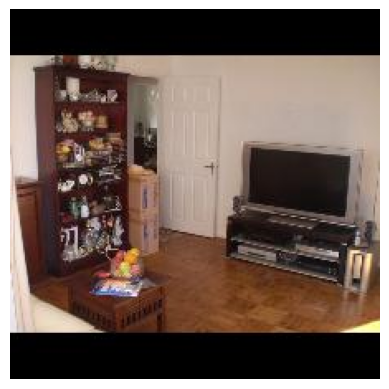

In [6]:
train_x_sample = load_images("pnp_dataset/train_x", limit=5, preprocess=False).astype(np.uint8)
plt.imshow(train_x_sample[4])
plt.axis('off')
train_y[0]

1

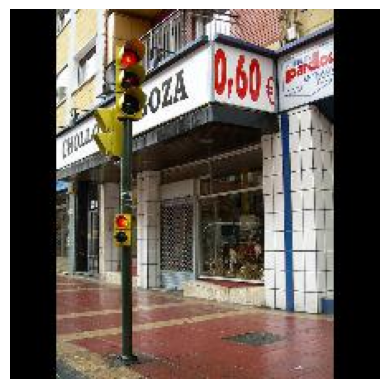

In [7]:
plt.imshow(train_x_sample[1])
plt.axis('off')
train_y[1]

In [8]:
# See MLFlow docs for more API examples.
# https://mlflow.org/docs/latest/python_api/mlflow.html

import mlflow
mlflow.set_experiment('PersonaNet')
mlflow.tensorflow.autolog(log_models=False, log_input_examples=False, log_model_signatures=False, silent=True)

In [9]:
mlflow.get_experiment_by_name('PersonaNet')

<Experiment: artifact_location='file:///app/mlflow/566790327807996370', creation_time=1697347471899, experiment_id='566790327807996370', last_update_time=1697347471899, lifecycle_stage='active', name='assignment_02', tags={}>

In [10]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
with tf.device('/CPU:0'):
    train_x = tf.constant(train_x)
    train_y = tf.constant(train_y)
    score_x = tf.constant(score_x)

In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load MobileNetV2 model with pre-trained weights
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

# Freeze all layers except the last few
for layer in mobile_net.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # Use sigmoid activation
])

model.summary()

model.compile(
    optimizer=SGD(learning_rate=0.05, momentum=0.9),
    loss='binary_crossentropy',  # Use binary cross-entropy
    metrics=[
        BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)

batch_size = 128
epochs = 3


model.fit(
    train_x,
    train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_x, val_y)
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_4 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

In [23]:
binary_accuracy2 = model.evaluate(val_x, val_y, verbose=0)[1]

print("Binary Accuracy:", binary_accuracy2)

Binary Accuracy: 0.8720625042915344


In [30]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Load MobileNetV2 model with pre-trained weights
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

# Freeze all layers except the last few
for layer in mobile_net.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Add padding
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Add padding
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])



model.summary()

model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='binary_crossentropy',  # Use binary cross-entropy
    metrics=[
        BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)

batch_size = 128
epochs = 2


model.fit(
    train_x,
    train_y,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_x, val_y)
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          737344    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                      

In [31]:
binary_accuracy4 = model.evaluate(val_x, val_y, verbose=0)[1]

print("Binary Accuracy:", binary_accuracy4)

Binary Accuracy: 0.8799375295639038
